In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

import numpy as np
import os
import data_utils
from keras.models import load_model

Using TensorFlow backend.


In [3]:
TOKENIZER_PATH = 'tokenizer.pickle'
TEXT_DATA_DIR = '20_newsgroup/'
MODEL_PATH = '20news_model.h5'

In [4]:
tokenizer = data_utils.load_tokenizer(TOKENIZER_PATH)
model = load_model(MODEL_PATH)
labels =  list(sorted(os.listdir(TEXT_DATA_DIR)))

In [5]:
sample_file = '20_newsgroup/alt.atheism/51060'
file_text = data_utils.load_textfile(sample_file)
file_features = data_utils.process_text(tokenizer, file_text)

In [11]:
pred_scores = model.predict(file_features)
orig_prediction = np.argmax(pred_scores[0])
print('Predicted "%s" with %f .' %(labels[orig_prediction], pred_scores[0][orig_prediction]))

Predicted "talk.religion.misc" with 0.148152 .


## Random Attack

 Random attack will pick and replace words randomly.

In [12]:
num_words = len(tokenizer.word_index)

In [17]:
ys = []
for i in range(1000):
    word_idx = np.random.choice(len(file_features[0]))
    file_features[0][word_idx] = np.random.choice(num_words)
    pred_scores = model.predict(file_features)
    ys.append(pred_scores[0][orig_prediction])

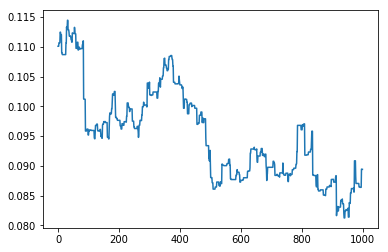

In [18]:
plt.plot(range(len(ys)), ys)

## Greedy Attack

 Greedy Attack will pick words based on their relevance to the source and target labels. 